In [1]:
%matplotlib inline

import os
import sys
import json

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Naive Bayes from - Sci Learn 
from sklearn.naive_bayes import BernoulliNB

# Split data for testing
from sklearn.model_selection import train_test_split

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))

from models import evaluation


# from models import evaluation
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights, 
                            load_data)

from features.process_features import get_vif, standardize
from features.process_features import MWI_BASIC_FEATURES

ALGORITHM_NAME = 'nb'
COUNTRY = 'mwi'
TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = get_country_filepaths(COUNTRY)

# load text of survey questions for reference
with open(QUESTIONS_PATH, 'r') as fp:
    questions = json.load(fp)

Using TensorFlow backend.


In [2]:
# Definition of Main Variables to Predict Poverty from the Household Survey

MWI_BASIC_FEATURES = [
    'der_nchild10under', 
    'der_nmalesover10', 
    'der_nfemalesover10',
    'der_nliterate', 
    'der_nemployedpastyear',
    'hld_electricity__Yes',
    'hld_toilet__None',
    'cons_0504__Yes',
    'cons_0508__Yes'
]

In [31]:
# Standardise Data
def standardize(df, numeric_only=True):
    if numeric_only is True:
    # find non-boolean columns
        cols = df.loc[:,df.dtypes != 'uint8'].columns
    else:
        cols = df.columns
    for field in cols:
        mean, std = df[field].mean(), df[field].std()
        # account for constant columns
        if np.all(df[field]-mean != 0):
            df.loc[:,field] = (df[field]-mean)/std
    
    return df

In [3]:
def drop_duplicate_columns(df, ignore=[], inplace=False):
    if not inplace:
        df = df.copy()

    # pairwise correlations
    corr = df.corr()
    corr[corr.columns] = np.triu(corr, k=1)
    corr = corr.stack()

    # for any perfectly correlated variables, drop one of them
    for ix, r in corr[(corr == 1)].to_frame().iterrows():
        first, second = ix

        if second in df.columns and second not in ignore:
            df.drop(second, inplace=True, axis=1)

    if not inplace:
        return df

In [33]:
# Split the data for analysis
def split_features_labels_weights(df,
                                  weights=['wta_pop', 'wta_hh'],
                                  weights_col=['wta_pop'],
                                  label_col=['poor']):

    '''Split data into features, labels, and weights dataframes'''
    data = df
    return (data.drop(weights + label_col, axis=1),
            data[label_col],
            data[weights_col])

In [4]:
# Load the processed Mwai household:
# mwi_hhold = pd.read_csv(r"C:\Users\micha\Documents\GitHub\mkp_code\Institute of Data Course\Project 3\data\csv_data\MWI_2010_household.csv")
mwi_hhold = pd.read_csv("/home/mike/Documents/mkp_code/Institute of Data Course/Project 3/data/csv_data/MWI_2010_household.csv")

In [5]:
# Split Malawi data 
mwi_train, mwi_test = train_test_split(mwi_hhold, 
                                       test_size=0.25,
                                       random_state=1443,
                                       stratify=mwi_hhold.poor)

In [6]:
# load training data
X_train, y_train, w_train = split_features_labels_weights(mwi_train)

In [7]:
# summarize loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*X_train.shape))

print('Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}' \
        .format(*y_train.poor.value_counts(normalize=True, ascending=True)))

# print first 5 rows of data
X_train.head()

Data has 9,183 rows and 485 columns
Percent poor: 45.1% 	Percent non-poor: 54.9%


,hid,der_hhsize,hld_rooms,hld_nbcellpho,hld_selfscale,der_nchild10under,der_nmalesover10,der_nfemalesover10,der_nliterate,der_nemployedpastyear,...,com_medicines__Yes,com_clinic__Yes,com_distclinic__11 to 15 kilometers,com_distclinic__16 to 20 kilometers,com_distclinic__21 to 25 kilometers,com_distclinic__26 to 30 kilometers,com_distclinic__6 to 10 kilometers,com_distclinic__Above 30 kilometers,com_distclinic__nan,com_bank__Yes
7927,304044580160,5,3,0.0,1.0,3,1,1,2,0,...,0,0,0,0,0,0,0,0,0,0
4210,205205820123,3,2,1.0,3.0,1,1,1,2,1,...,1,0,0,0,0,0,0,0,0,0
457,102016880095,6,5,0.0,2.0,3,1,2,2,0,...,0,0,0,0,0,0,0,0,0,0
11951,315356330210,3,3,3.0,3.0,1,1,1,3,1,...,1,1,0,0,0,0,0,0,1,1
11428,313061660067,2,1,0.0,2.0,0,1,1,2,0,...,1,0,0,1,0,0,0,0,0,0


In [8]:
# Fit the model
model = BernoulliNB()
%time model.fit(X_train, y_train)

CPU times: user 59.4 ms, sys: 0 ns, total: 59.4 ms
Wall time: 139 ms


BernoulliNB()

In [9]:
# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

CPU times: user 62.2 ms, sys: 2.6 ms, total: 64.8 ms
Wall time: 154 ms
In-sample score: 75.66%


In [10]:
# Run the model
y_pred = model.predict(X_train)
y_prob = model.predict_proba(X_train)[:,1]

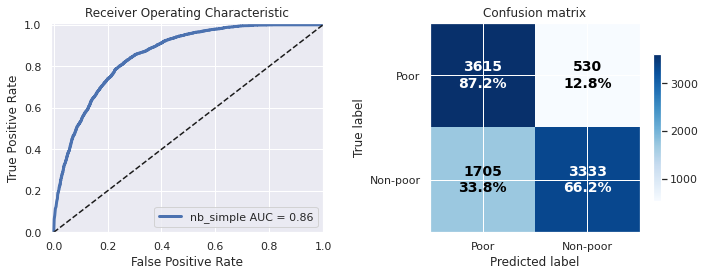

,nb_simple
accuracy,0.756615
recall,0.872135
precision,0.679511
f1,0.763867
cross_entropy,2.947750
roc_auc,0.856952
cohen_kappa,0.520627


In [11]:
# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_train, y_pred, y_prob, 
                                    compare_models=['lr_simple'],
                                    store_model=True,
                                    model_name='simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=X_train.columns.values)

In [12]:
# load testing data
X_test, y_test, w_test = split_features_labels_weights(mwi_test)

In [13]:
# summarize loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*X_test.shape))

print('Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}' \
        .format(*y_test.poor.value_counts(normalize=True, ascending=True)))

# print first 5 rows of data
X_test.head()

Data has 3,061 rows and 485 columns
Percent poor: 45.1% 	Percent non-poor: 54.9%


,hid,der_hhsize,hld_rooms,hld_nbcellpho,hld_selfscale,der_nchild10under,der_nmalesover10,der_nfemalesover10,der_nliterate,der_nemployedpastyear,...,com_medicines__Yes,com_clinic__Yes,com_distclinic__11 to 15 kilometers,com_distclinic__16 to 20 kilometers,com_distclinic__21 to 25 kilometers,com_distclinic__26 to 30 kilometers,com_distclinic__6 to 10 kilometers,com_distclinic__Above 30 kilometers,com_distclinic__nan,com_bank__Yes
10396,311040860017,7,2,0.0,3.0,0,3,4,0,0,...,1,0,0,0,0,0,0,0,0,0
5957,210370300058,6,3,5.0,4.0,0,4,2,4,1,...,1,0,0,0,0,0,0,0,0,0
7847,304034440117,6,5,1.0,3.0,3,2,1,2,1,...,1,1,0,0,0,0,0,0,1,0
10050,310016470133,7,2,0.0,2.0,4,1,2,2,0,...,1,0,0,0,0,0,1,0,0,0
7475,303055060022,2,2,1.0,2.0,0,1,1,2,0,...,1,0,0,0,0,0,0,0,0,0


In [14]:
# Fit the model
model = BernoulliNB()
%time model.fit(X_test, y_test)

CPU times: user 24.3 ms, sys: 170 µs, total: 24.4 ms
Wall time: 49.8 ms


BernoulliNB()

In [15]:
# Get an initial score
%time score = model.score(X_test, y_test)
print("In-sample score: {:0.2%}".format(score))

CPU times: user 23.1 ms, sys: 0 ns, total: 23.1 ms
Wall time: 47.6 ms
In-sample score: 75.24%


In [16]:
# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

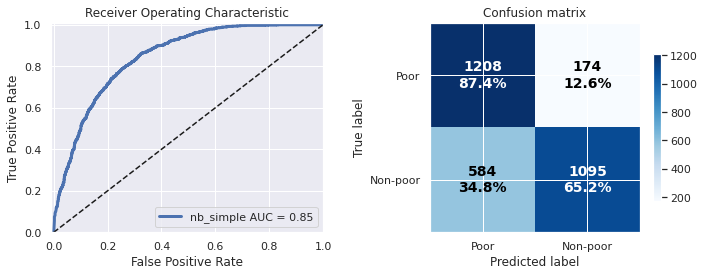

,nb_simple
accuracy,0.752369
recall,0.874096
precision,0.674107
f1,0.761185
cross_entropy,3.119443
roc_auc,0.845202
cohen_kappa,0.512814


In [17]:
# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, 
                                    compare_models=['lr_simple'],
                                    store_model=True,
                                    model_name='simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=X_test.columns.values)